Estimated Coefficients (OLS): [ 0.00038378 -0.04028167]
Optimal Prices: [4.68907627e+53 3.56882655e+53 5.32961730e+52 6.04423485e+52]


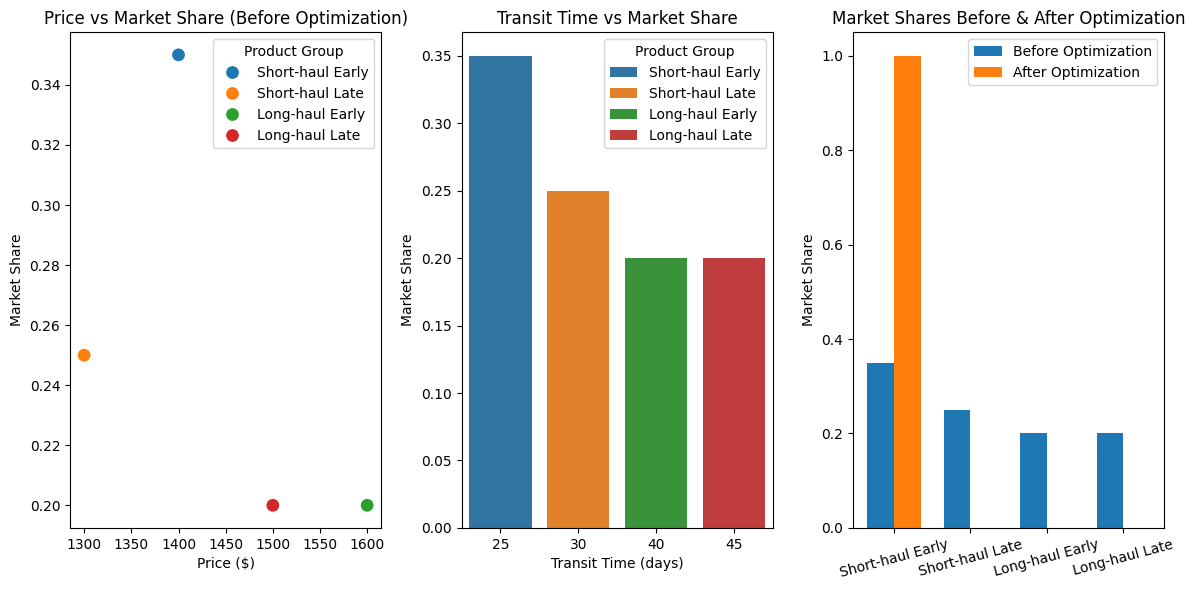

In [5]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Simulated aggregated market share data
data = pd.DataFrame({
    "ProductGroup": ["Short-haul Early", "Short-haul Late", "Long-haul Early", "Long-haul Late"],
    "Price": [1400, 1300, 1600, 1500],
    "TransitTime": [25, 30, 40, 45],
    "MarketShare": [0.35, 0.25, 0.20, 0.20]  # Aggregated market shares per group
})

# Transform market shares to logit-transformed shares
logit_shares = np.log(data["MarketShare"] / (1 - data["MarketShare"]))

# Prepare data for OLS regression
X = data[["Price", "TransitTime"]]  # Independent variables
y = logit_shares  # Dependent variable (logit-transformed market shares)

# Estimate parameters using OLS
model = LinearRegression()
model.fit(X, y)
beta = model.coef_
print("Estimated Coefficients (OLS):", beta)

# Revenue optimization function
def revenue_function(prices):
    U_opt = beta[0] * prices + beta[1] * data["TransitTime"].values  # Compute utility
    exp_U = np.exp(U_opt - np.max(U_opt))  # Prevent overflow
    S_opt = exp_U / np.sum(exp_U)  # Predicted market shares
    revenue = np.sum(S_opt * prices)  # Total revenue
    return -revenue  # Minimize negative revenue to maximize revenue

# Optimize prices across product groups
optimal_prices = opt.minimize(revenue_function, data["Price"].values, method='Nelder-Mead').x
print("Optimal Prices:", optimal_prices)

# Compute expected market shares for optimal prices
U_opt = beta[0] * optimal_prices + beta[1] * data["TransitTime"].values
exp_U_opt = np.exp(U_opt - np.max(U_opt))  # Prevent overflow
expected_market_shares = exp_U_opt / np.sum(exp_U_opt)

# Visualization
plt.figure(figsize=(12, 6))

# Scatter plot of Price vs. Market Share
plt.subplot(1, 3, 1)
sns.scatterplot(x=data["Price"], y=data["MarketShare"], hue=data["ProductGroup"], s=100)
plt.xlabel("Price ($)")
plt.ylabel("Market Share")
plt.title("Price vs Market Share (Before Optimization)")
plt.legend(title="Product Group")

# Bar plot of Transit Time vs. Market Share
plt.subplot(1, 3, 2)
sns.barplot(x=data["TransitTime"], y=data["MarketShare"], hue=data["ProductGroup"])
plt.xlabel("Transit Time (days)")
plt.ylabel("Market Share")
plt.title("Transit Time vs Market Share")
plt.legend(title="Product Group")

# Bar plot comparing market shares before and after optimization
plt.subplot(1, 3, 3)
x_labels = data["ProductGroup"]
x = np.arange(len(x_labels))
width = 0.35
plt.bar(x - width/2, data["MarketShare"], width, label='Before Optimization')
plt.bar(x + width/2, expected_market_shares, width, label='After Optimization')
plt.xticks(ticks=x, labels=x_labels, rotation=15)
plt.ylabel("Market Share")
plt.title("Market Shares Before & After Optimization")
plt.legend()

plt.tight_layout()
plt.show()